In [44]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
from nba_api.stats.endpoints import leaguedashteamstats, playerawards

fig_DIR = "../figs/analysis//"
box_DIR = "../data/box/"

pID_dict = get_pID_pbp()
player_dict = get_players_pbp()
teams_dict, teams_list = get_teams()

In [45]:
df1 = pd.read_parquet("../data/misc/"+"NBA_Awards_2024.parquet")
df1.columns = map(str.lower, df1.columns)

In [98]:
award_list = ['NBA All-Star','All-NBA']
df2 = df1[df1["description"].isin(award_list)]
cols = ['person_id' ,'season', "description"]
df2 = df2[cols]
df2 = df2.rename(columns={"person_id":"player_id"})
df2["season"] = df2["season"].str[:-3]
df2["season"] = df2["season"].astype(int) + 1
df2 = df2.sort_values(["player_id","season"])
pIDas = df2["player_id"].to_list()
df2["all_nba"] = np.where(df2["description"] == 'All-NBA',True,False)
df2["all_star"] = np.where(df2["description"] == 'NBA All-Star',True,False)
df2 =df2.drop(columns="description")
df2 = df2.groupby(["player_id","season"])[["all_nba","all_star"]].sum()
df2 = df2.reset_index()
df2["all_star"] = df2["all_star"].astype(bool)
df2["all_nba"] = df2["all_nba"].astype(bool)

In [100]:
dfa = []
for season in range(1996,2025):
    cols= ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION','AGE', 'GP', ]
    df3 = pd.read_parquet(box_DIR + f"NBA_Box_P_Cum_Base_{season}.parquet",columns=cols)
    df3.columns = map(str.lower, df3.columns)
    df3["season"] = season + 1 
    dfa.append(df3)
df4 = pd.concat(dfa)
df5 = pd.merge(df4,df2,on=["player_id","season"],how="left")
df5 = df5.sort_values(["player_id","season"]).reset_index(drop=True)
df5["all_star"] = np.where(df5["all_star"]==True, True,False)
df5["all_nba"] = np.where(df5["all_nba"]==True, True,False)
df5["all_star"] = df5["all_star"].astype(bool)
df5["all_nba"] = df5["all_nba"].astype(bool)

In [135]:
df6 = df5[df5["player_id"].isin(pIDas)]
df6["count"]= np.where((df6["all_star"] | df6["all_nba"]), 1, 0)
df6g = df6.groupby(["player_id","player_name"])
keys = list(df6g.groups)
dfb = []
for key in keys:
    df7 = df6g.get_group(key)
    df7["wind"] = df7["count"].rolling(3).sum()
    df7["star"] = df7["wind"] > 0
    dfb.append(df7)
df8 = pd.concat(dfb)
df8 = df8.dropna().reset_index(drop=True)
df8 = df8.query("star == True").reset_index(drop=True)

In [137]:
dfb = []
for season in range(1996,2025):
    cols= ['TEAM_ID', 'GP', ]
    dftb = pd.read_parquet(box_DIR + f"NBA_Box_T_Cum_Base_{season}.parquet",columns=cols)
    dftb.columns = map(str.lower, dftb.columns)
    dftb["season"] = season + 1 
    dfb.append(dftb)
df9 = pd.concat(dfb)

In [138]:
df10 = pd.merge(df8,df9,on=["team_id","season"],how="left",suffixes=["_p","_t"])
# df10 = df10.query("season >= 2000")
df10 = df10.query("season >= 2000 & season < 2025")
df10["gm"] = df10["gp_t"] - df10["gp_p"]
df11 = df10.groupby(["season"])[["gm","gp_t","age"]].mean()
df11 = df11.reset_index()
df11["gp_t"] = df11["gp_t"].astype(int)
df11["gm_pg"] = df11["gm"]/df11["gp_t"]
df11["gm"] = df11["gm"].round(1)
df11["gm_pg"] = df11["gm_pg"].round(4)

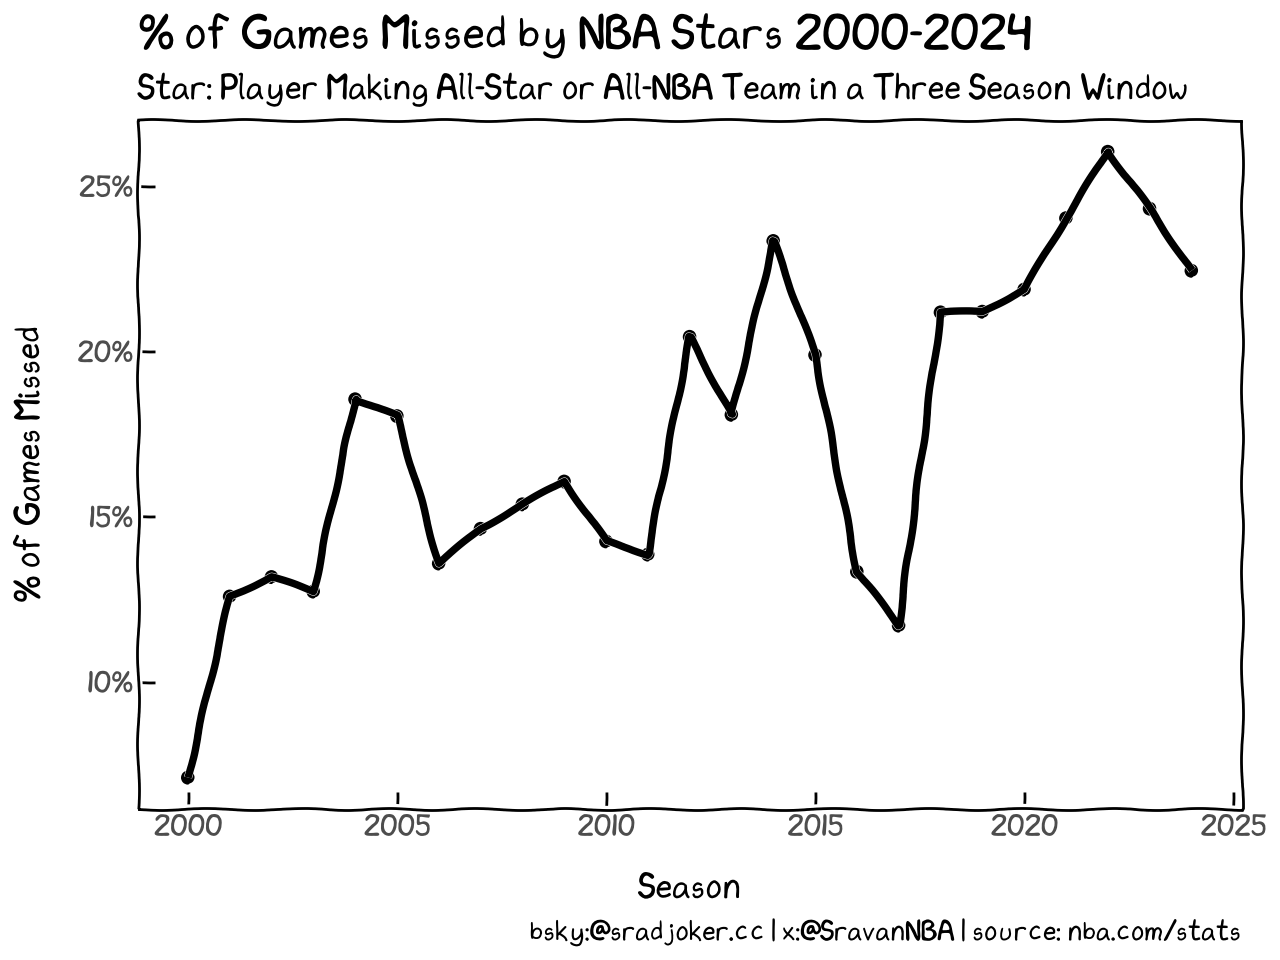

In [139]:
data = df11.copy()
p = (
    ggplot(data)
    + aes(x="season",y="gm_pg",group=0)
    + geom_point()
    + geom_line(size=1.5)
    + scale_y_continuous(labels=percent_format())
    + theme_idv
    + labs(
        title = "% of Games Missed by NBA Stars 2000-2024",
        subtitle = "Star: Player Making All-Star or All-NBA Team in a Three Season Window",
        caption="bsky:@sradjoker.cc | x:@SravanNBA | source: nba.com/stats",
        x = "Season",
        y = "% of Games Missed",
    )
)
p

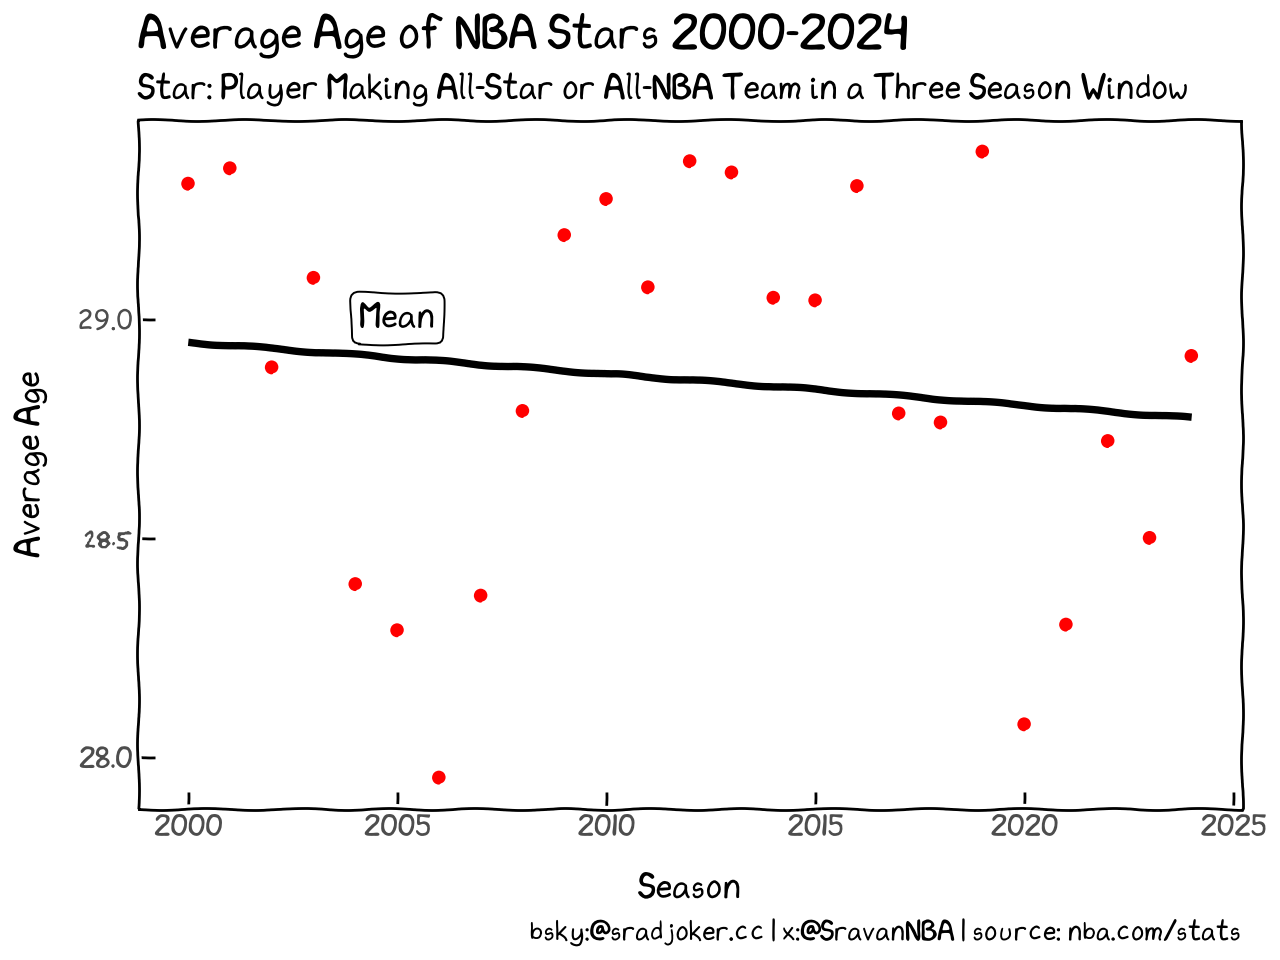

In [141]:
data = df11.copy()
p = (
    ggplot(data)
    + aes(x="season",y="age",group=0)
    + geom_point(color="red")
    # + geom_line(size=1.5)
    + geom_smooth(method="lm",se=False, size=1.5)
    # + geom_smooth(method="lm",se=True, size=1.5)
    # + scale_y_continuous(labels=percent_format())
    + annotate("label",2005,29,label="Mean",size=12)
    + theme_idv
    + labs(
        title = "Average Age of NBA Stars 2000-2024",
        subtitle = "Star: Player Making All-Star or All-NBA Team in a Three Season Window",
        caption="bsky:@sradjoker.cc | x:@SravanNBA | source: nba.com/stats",
        x = "Season",
        y = "Average Age",
    )
)
p

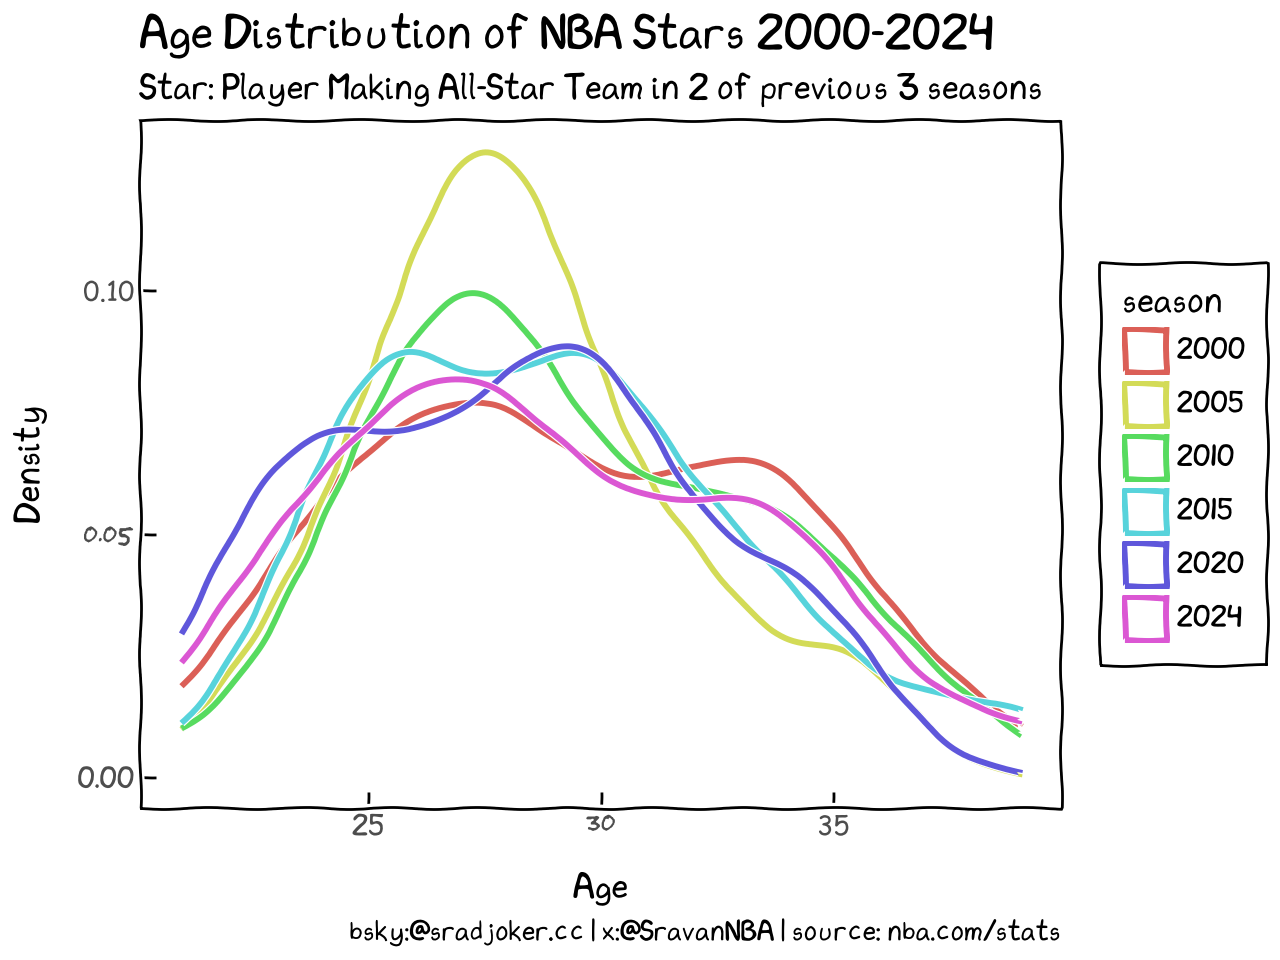

In [ ]:
seasons = [2000,2005,2010,2015,2020,2024]
data = df10.copy()
data = data[data.season.isin(seasons)]
data["season"] = data["season"].astype("category")
p = (
    ggplot(data)
    + aes(x="age",group="season",color="season")
    + geom_density(size=1.2)
    + theme_idv
    + labs(
        title = "Age Distribution of NBA Stars 2000-2024",
        subtitle = "Star: Player Making All-Star or All-NBA Team in a Three Season Window",
        caption="bsky:@sradjoker.cc | x:@SravanNBA | source: nba.com/stats",
        x = "Age",
        y = "Density",
    )
)
p

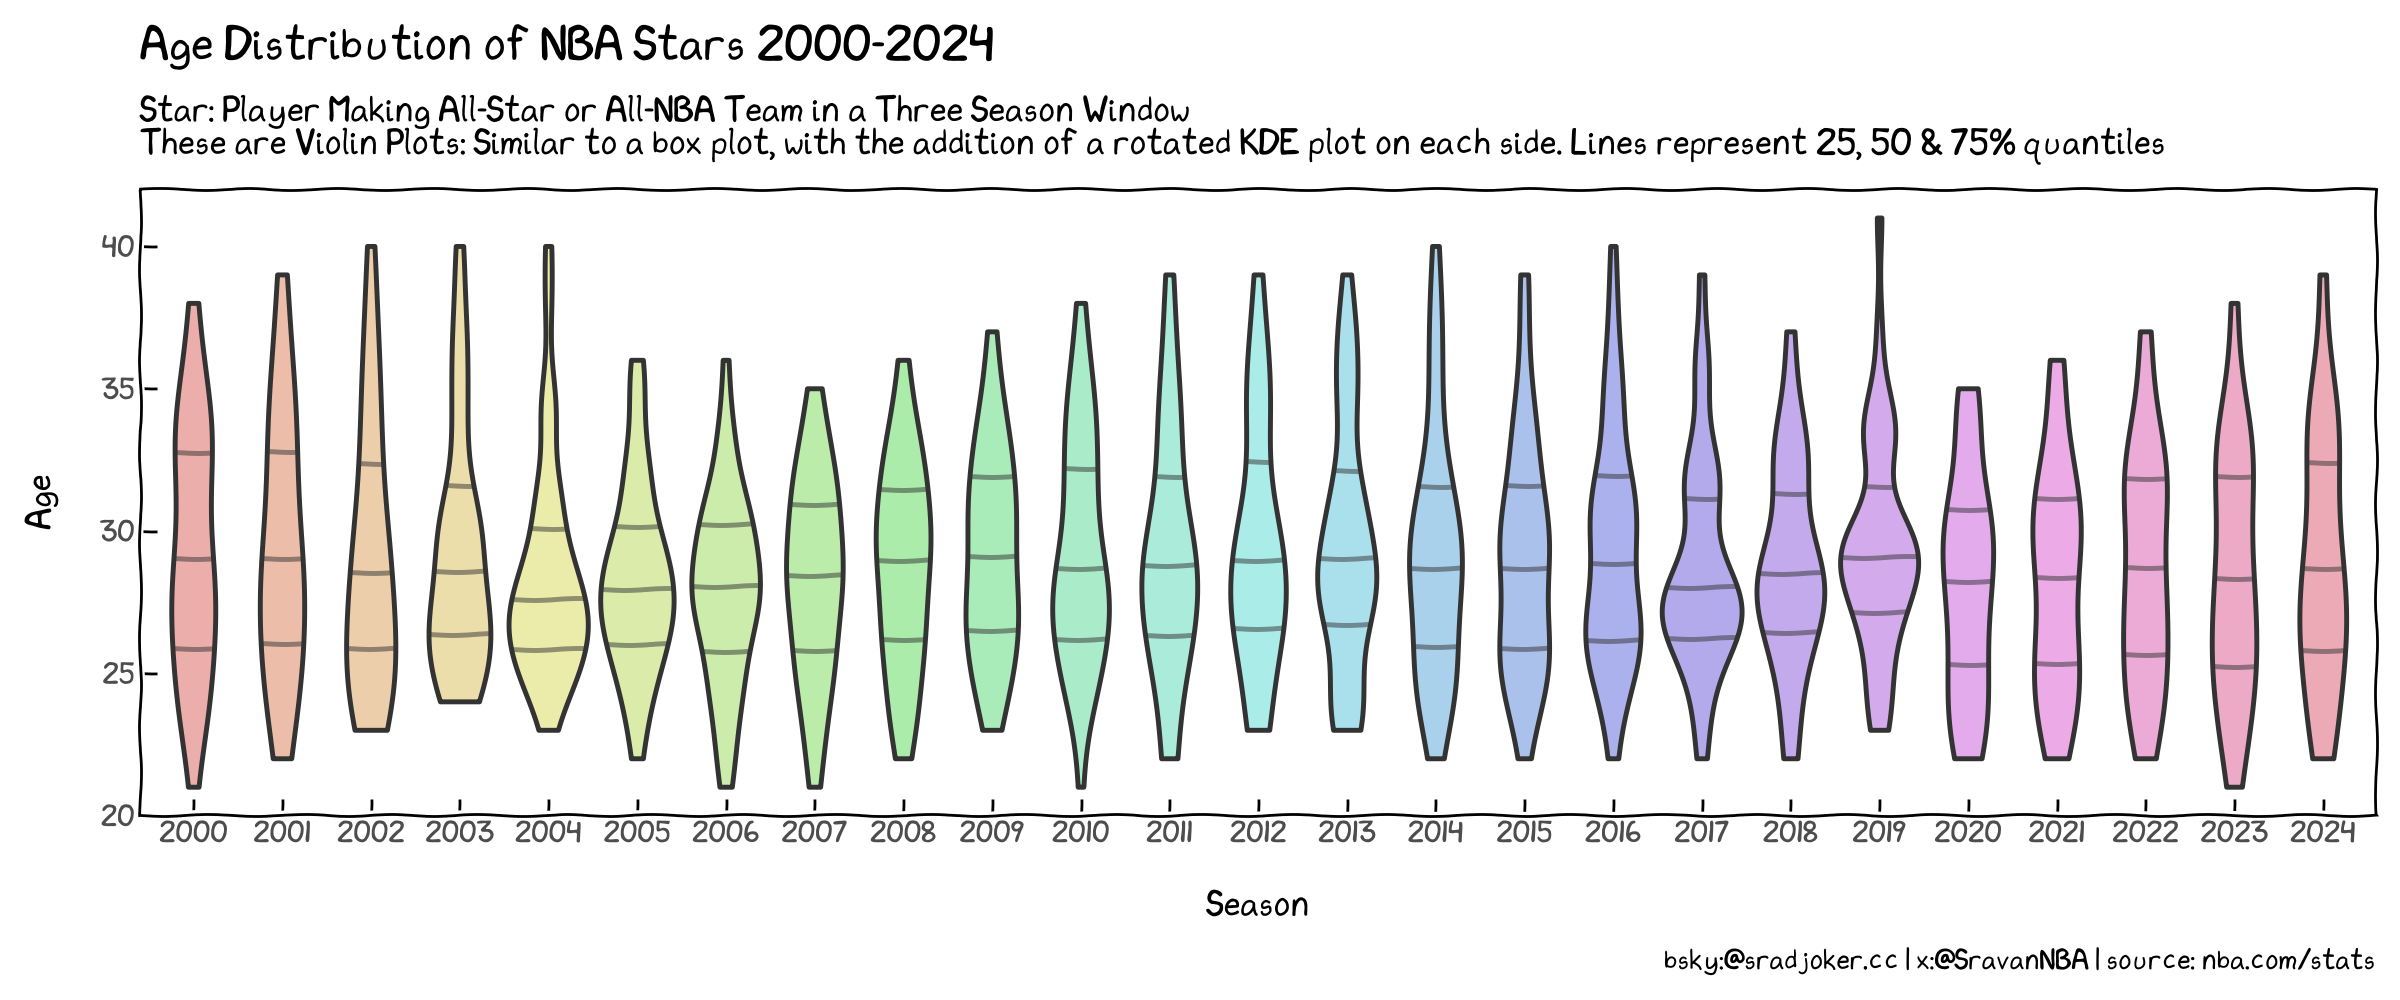

In [159]:
data = df10.copy()
data["season"] = data["season"].astype("category")
p = (
    ggplot(data)
    + aes(x="season",y="age",fill="season")
    + geom_violin(draw_quantiles=[0.25,0.5,0.75], alpha=0.5, show_legend=False, size=1)
    + theme_idv
    + theme(
        figure_size=(12,5)
    )
    + labs(
        title = "Age Distribution of NBA Stars 2000-2024",
        subtitle = "Star: Player Making All-Star or All-NBA Team in a Three Season Window\nThese are Violin Plots: Similar to a box plot, with the addition of a rotated KDE plot on each side. Lines represent 25, 50 & 75% quantiles",
        caption="bsky:@sradjoker.cc | x:@SravanNBA | source: nba.com/stats",
        y = "Age",
        x = "Season",
    )
)
p